In [2]:
import ateam.data.lims as lims

reload(lims)
lr = lims.LimsReader()

We'll start with a cell in the original human IVSCC database (released in the web product).

In [3]:
cell_id = 489315717
lr.get_cells_df(cells_list=[cell_id])

,name,normalized_depth,soma_depth_um,structure,donor_name,dendrite_type,layer,project_code,nwb_path
id,,,,,,,,,
489315717,H15.06.018.02.03.02,None,None,middle temporal gyrus,H15.06.018,dendrite type - spiny,Layer 3,H301,/allen/programs/celltypes/production/humancell...


## Accessing basic sweep data

The following function is defined in my ateam.data.lims module; we'll go through it piece by piece

In [4]:
def get_sweep_v_i_t_lims(cell_id, sweep_num):
    lr = LimsReader()
    nwb_path = lr.get_nwb_path_from_lims(cell_id)
    dataset = NwbDataSet(nwb_path)
    v, i, t = get_sweep_v_i_t_from_set(dataset, sweep_num)
    return v, i, t

Get the path from LIMS:

In [5]:
nwb_path = lr.get_nwb_path_from_lims(cell_id)
print(nwb_path)

/allen/programs/celltypes/production/humancelltypes/prod6/Ephys_Roi_Result_489315715/489315715.nwb


Load the NWB file using the AllenSDK NwbDataSet class:

In [6]:
from allensdk.core.nwb_data_set import NwbDataSet
dataset = NwbDataSet(nwb_path)

In [7]:
print(NwbDataSet.__doc__)

 A very simple interface for exracting electrophysiology data
    from an NWB file.
    


This class is mainly useful for its get_sweep method, which pulls out all the data we need for a given sweep into a tidy dict format

In [8]:
print(NwbDataSet.get_sweep.__doc__)

 Retrieve the stimulus, response, index_range, and sampling rate
        for a particular sweep.  This method hides the NWB file's distinction
        between a "Sweep" and an "Experiment".  An experiment is a subset of
        of a sweep that excludes the initial test pulse.  It also excludes
        any erroneous response data at the end of the sweep (usually for
        ramp sweeps, where recording was terminated mid-stimulus).

        Some sweeps do not have an experiment, so full data arrays are
        returned.  Sweeps that have an experiment return full data arrays
        (include the test pulse) with any erroneous data trimmed from the
        back of the sweep.

        Parameters
        ----------
        sweep_number: int

        Returns
        -------
        dict
            A dictionary with 'stimulus', 'response', 'index_range', and
            'sampling_rate' elements.  The index range is a 2-tuple where
            the first element indicates the end of the test 

Note that this docstring is actually misleading - the method never actually trims the sweep itself. You need to use the "index_range" to filter the data the proper time interval manually if desired. We do this trimming and unit conversion in the simple function below:

In [9]:
def get_sweep_v_i_t_from_set(data_set, sweep_num, window_data=True):
    sweep_data = data_set.get_sweep(sweep_num)
    i = sweep_data["stimulus"] # in A
    v = sweep_data["response"] # in V
    if window_data:
        index_range = sweep_data["index_range"]
        i = i[index_range[0]:index_range[1]]
        v = v[index_range[0]:index_range[1]]
    i *= 1e12 # to pA
    v *= 1e3 # to mV
    sampling_rate = sweep_data["sampling_rate"] # in Hz
    t = np.arange(0, len(v)) * (1.0 / sampling_rate)
    return v, i, t

We'll find sweeps of interest by sweep type using LIMS tools, then plot them with this method.

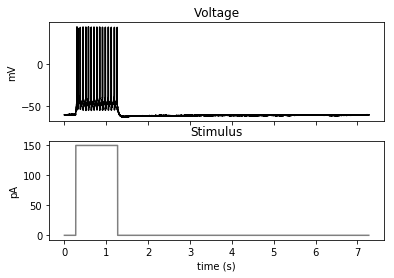

In [10]:
sweeps = lr.get_sweeps(cell_id, sweep_type='Long Square', passed_only=True)
sweep_num = sweeps[10]
v, i, t = lims.get_sweep_v_i_t_from_set(dataset, sweep_num)
lims.plot_sweep(v, i, t)

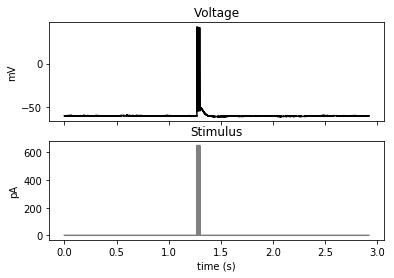

In [11]:
sweeps = lr.get_sweeps(cell_id, sweep_type='Short Square - Triple', passed_only=True)
sweep_num = sweeps[0]
v, i, t = lims.get_sweep_v_i_t_from_set(dataset, sweep_num)
lims.plot_sweep(v, i, t)

Note that we could also do this just with a call to `lims.plot_sweep_lims(cell_id, sweep_num)`

## Sending to AllenSDK feature extraction

In [12]:
from allensdk.ephys.ephys_extractor import EphysSweepFeatureExtractor
sweep = EphysSweepFeatureExtractor(t=t, v=v, i=i)
sweep.process_spikes()

In [13]:
sweep.spikes()[0]

{'adp_i': nan,
 'adp_index': nan,
 'adp_t': nan,
 'adp_v': nan,
 'clipped': False,
 'downstroke': -115.41178767441555,
 'downstroke_index': 63654,
 'downstroke_t': 1.2730800000000002,
 'downstroke_v': 20.53125,
 'fast_trough_i': 0,
 'fast_trough_index': 63720,
 'fast_trough_t': 1.2744000000000002,
 'fast_trough_v': -54.40625,
 'isi_type': 'direct',
 'peak_i': 650,
 'peak_index': 63637,
 'peak_t': 1.2727400000000002,
 'peak_v': 42.125,
 'slow_trough_i': nan,
 'slow_trough_index': nan,
 'slow_trough_t': nan,
 'slow_trough_v': nan,
 'threshold_i': 650,
 'threshold_index': 63613,
 'threshold_t': 1.2722600000000002,
 'threshold_v': -43.281253814697266,
 'trough_i': 0,
 'trough_index': 63731,
 'trough_t': 1.27462,
 'trough_v': -54.625,
 'upstroke': 352.29751302805363,
 'upstroke_downstroke_ratio': 3.0525262637981894,
 'upstroke_index': 63625,
 'upstroke_t': 1.2725000000000002,
 'upstroke_v': -4.562500476837158,
 'width': 0.0008799999999999919}

### What about MET cells?

The should all work essentially the same for cells in the MET dataset for instance, with a possible issues shown below. In this case, the long square sweeps are fine, but not the triblip.

In [14]:
cell_id = 651059305
lr.get_cells_df(cells_list=[cell_id])

nwb_path = lr.get_nwb_path_from_lims(cell_id)
dataset = NwbDataSet(nwb_path)
lr.get_cells_df(cells_list=[cell_id])

,name,normalized_depth,soma_depth_um,structure,donor_name,dendrite_type,layer,project_code,nwb_path
id,,,,,,,,,
651059305,Rbp4-Cre_KL100;Ai14-362155.04.02.03,0.56945,608.233429,"Primary visual area, layer 5",Rbp4-Cre_KL100;Ai14-362155,None,Layer 5,mIVSCC-MET,/allen/programs/celltypes/production/mousecell...


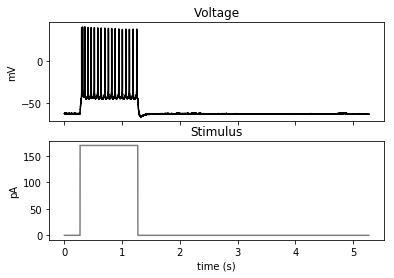

In [15]:
sweeps = lr.get_sweeps(cell_id, sweep_type='Long Square', passed_only=True)
sweep_num = sweeps[0]
v, i, t = lims.get_sweep_v_i_t_from_set(dataset, sweep_num)
lims.plot_sweep(v, i, t)

In this case, the triblip sweeps apparently did not pass QC (in general, the QC flag is unlikely to be reliable for new datasets, so it's best not to use it without finding out details first).

Additionally, the start/end times stored in the file are wrong (maybe related to the QC issue), so the windowed plot is wrong, but we can still plot the full sweep, including the test pulse (and could start our analysis from there).

Note that (like my code here), some of the AllenSDK feature extraction methods in `allensdk.ephys.ephys_extractor` do this windowing automatically, and so may fail in some cases for early-stage or off-pipeline data if not used with care. Any method that starts with timeseries input directly (like our call to `EphysSweepFeatureExtractor(t=t, v=v, i=i)` above) will still be fine.

0 sweeps passed
33 sweeps total


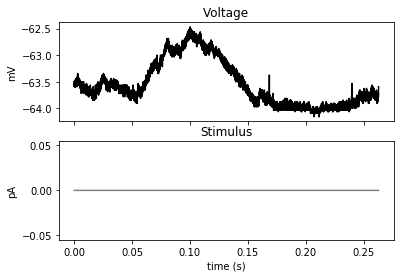

In [16]:
sweeps = lr.get_sweeps(cell_id, sweep_type='Short Square - Triple', passed_only=True)
print("{} sweeps passed".format(len(sweeps)) )
sweeps = lr.get_sweeps(cell_id, sweep_type='Short Square - Triple', passed_only=False)
print("{} sweeps total".format(len(sweeps)) )
sweep_num = sweeps[0]
v, i, t = lims.get_sweep_v_i_t_from_set(dataset, sweep_num, window_data=True)
lims.plot_sweep(v, i, t)

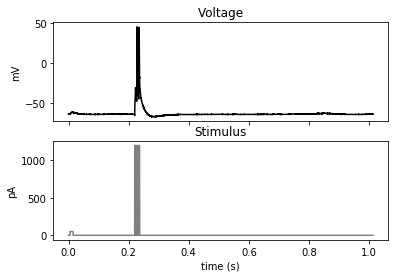

In [17]:
v, i, t = lims.get_sweep_v_i_t_from_set(dataset, sweep_num, window_data=False)
lims.plot_sweep(v, i, t)

### Accessing through h5 directly

If we didn't have access to the LIMS info to decide which sweeps to look at by type, we could also use information embedded in the file itself, in the field `aibs_stimulus_description`.
However, interpreting this information correctly may be trickier, as it is less standardized. (This is what Anatoly's `convert_igor_nwb.py` does.)

Note also that, as Luke reminded us, there may be other hidden pitfalls with reading any data directly from the h5.

In [18]:
import h5py
f = h5py.File(nwb_path, "r")

stim_desc_path = 'acquisition/timeseries/Sweep_{}/aibs_stimulus_description/'.format(sweep_num)
print(f.get(stim_desc_path).value[0])

C2SSTRIPLE171103_DA_0


## Accessing the "web version" NWB through LIMS

LIMS actually can have several different NWB types, distinguished by their "well_known_file_type"

NWB 	
NWBUncompressed 	
NWBDownload 	
NWBISI 	
NWBOphys 	
NWBIgor 	
NWB2 



The *NWBDownload* type is (I believe) the processed version used in the web product. We can ask my function to return that version too.

We see that it now contains metadata in the sweeps.

In [19]:
cell_id = 489315717
nwb_path =lr.get_nwb_path_from_lims(cell_id, get_sdk_version=True)
dataset = NwbDataSet(nwb_path)
print(nwb_path)

/allen/programs/celltypes/production/humancelltypes/prod6/Ephys_Roi_Result_489315715/489315715_ephys.nwb


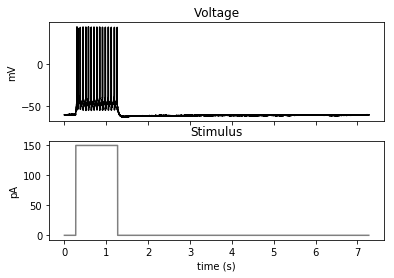

In [20]:
sweeps = lr.get_sweeps(cell_id, sweep_type='Long Square', passed_only=True)
sweep_num = sweeps[10]
v, i, t = lims.get_sweep_v_i_t_from_set(dataset, sweep_num)
lims.plot_sweep(v, i, t)

In [21]:
dataset.get_sweep_metadata(sweep_num)

{'aibs_stimulus_amplitude_pa': 149.999998533268,
 'aibs_stimulus_name': u'Long Square',
 'initial_access_resistance': 7.9403255,
 'seal': 1.389192192}

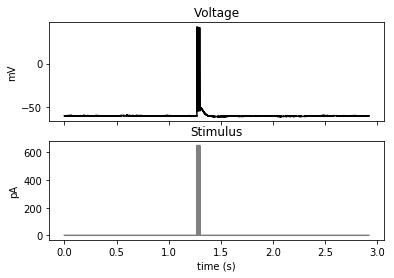

In [22]:
sweeps = lr.get_sweeps(cell_id, sweep_type='Short Square - Triple', passed_only=True)
sweep_num = sweeps[0]
v, i, t = lims.get_sweep_v_i_t_from_set(dataset, sweep_num)
lims.plot_sweep(v, i, t)

In [23]:
dataset.get_sweep_metadata(sweep_num)

{'aibs_stimulus_amplitude_pa': 649.99999827009,
 'aibs_stimulus_name': u'Short Square - Triple',
 'initial_access_resistance': 7.9403255,
 'seal': 1.389192192}